Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

dataset

In [3]:
inp = ['''0.7 0.7 0.7 0.7 0.7 0.7 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.85 
0.85 0.85 0.85 0.85 0.85 0.85 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.95 0.95 0.95 0.95 0.95 0.95 0.95 
0.95 0.95 1 1 1 1 1 1 1 1 1.05 1.05 1.05 1.05 1.05 1.05 1.05 1.05 1.05 1.1 1.1 1.1 1.1 1.1 1.1 1.1 
1.1 1.1 1.1''',
'''245 280 340 400 440 465 265 320 360 400 440 460 495 280 320 360 420 480 520 530 
300 360 400 440 480 520 560 315 360 400 440 480 520 560 600 
330 380 420 460 500 540 580 620 630 350 420 450 500 540 580 620 665 
370 420 480 525 550 580 620 660 695 385 420 460 490 510 560 600 640 680 730''',
'''1.145 1.140 1.13 1.11 1.09 1.08 1.166 1.16 1.15 1.14 1.12 1.11 1.08 1.19 1.185 
1.18 1.16 1.13 1.105 1.095 1.22 1.21 1.20 1.185 1.17 1.144 1.11 1.246 1.24 1.232 1.22 1.205 
1.183 1.155 1.12 1.276 1.27 1.26 1.25 1.23 1.21 1.18 1.145 1.135 1.31 1.3 1.29 1.27 1.25 1.23 
1.195 1.15 1.345 1.34 1.32 1.30 1.29 1.27 1.245 1.21 1.165 1.382 1.38 1.37 1.36 1.35 1.33 
1.305 1.275 1.24 1.18'''
]

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, inp):
        super(Dataset, self).__init__()
        self.data = list(zip(map(float, inp[0].split()), map(float, inp[1].split())))
        self.data = torch.Tensor(self.data)
        self.lable = list(map(float, inp[2].split()))
        self.lable = torch.Tensor(self.lable)

    def __getitem__(self, index):
        data = self.data[index]
        lable = self.lable[index]
        return data, lable

    def __len__(self):
        return len(self.lable)

In [5]:
data = Dataset(inp)

In [6]:
data.__len__()

71

trai valid test split

In [7]:
import torch.utils


train, val, test = torch.utils.data.random_split(data, [51, 10, 10])

Create dataloader

In [8]:
dataloader_train = torch.utils.data.DataLoader(train, 1, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(val, 1, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(test, 1, shuffle=True)

model (Net)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pipe = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            
            nn.Linear(10 , 1)
        )


    def forward(self, x):
        x = self.pipe(x)
        return x

In [10]:
model = Net()
model.to(device)

Net(
  (pipe): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

test

In [11]:
def test(model, dataloader):
    score = []
    for data in tqdm(dataloader):
        inp, lable = data
        inp, lable = inp.to(device), lable.to(device)

        out = model(inp)

        score.append(abs((lable-out).item()))
    score = np.array(score)
    return score.mean()
        

train

In [12]:
def train(model, valloader, trainloader, optimizer, criterion, epoch):

    loss_stats = {
        "loss_func":[],
        "valid_loss":[]
    }

    for ep in range(epoch):
        model.train()
        running_loss = 0
        for data in (bar := tqdm(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()

            bar.set_description(f'epoch: {ep}\tloss: {running_loss:.3F}')

        loss_stats["loss_func"].append(running_loss)

        model.eval()

        loss_stats["valid_loss"].append(test(model, valloader))
    return loss_stats

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [14]:
stats = train(
    model, 
    dataloader_val,
    dataloader_train,
    optimizer,
    criterion,
    100
    )

  0%|          | 0/51 [00:00<?, ?it/s]c:\Users\Filic\.conda\envs\pythorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 10/10 [00:00<00:00, 1666.85it/s]


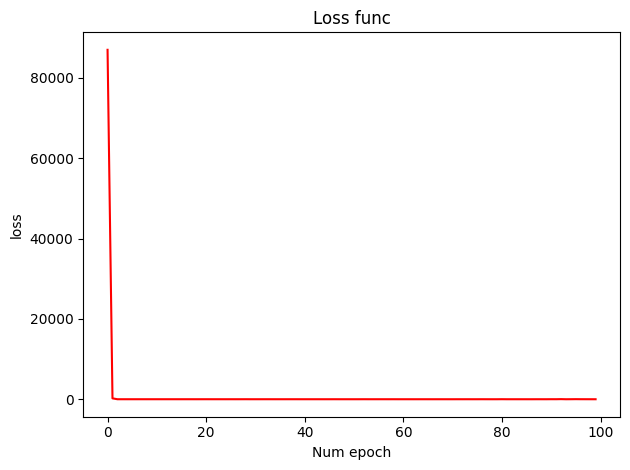

In [15]:
plt.title('Loss func')
plt.xlabel('Num epoch')
plt.ylabel('loss')

plt.plot(stats['loss_func'], 'r')

plt.tight_layout()

plt.show()

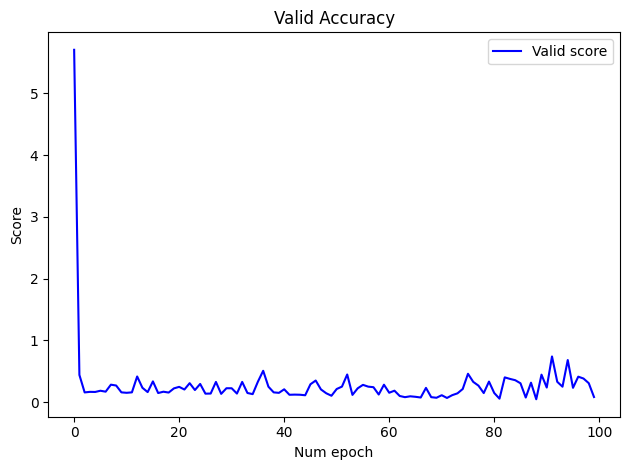

In [16]:
plt.title('Valid Accuracy')
plt.xlabel('Num epoch')
plt.ylabel('Score')

plt.plot(stats['valid_loss'], 'b', label='Valid score')

plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

Test score

In [17]:
print(f'Test score: {test(model, dataloader_test)}')

100%|██████████| 10/10 [00:00<00:00, 400.06it/s]

Test score: 0.1021348476409912
